# Data Example: arealstatistik (raster), and working with Canton shapefiles (vector)

This Notebook has two goals:

1. To introduce you to the Federal dataset 'arealstatistik'
2. <a href="#shapefiles">To show how you can clip raster files with shapefiles, here using the Swiss Cantons.</a>

---

In [3]:
# reload module before executing code
%load_ext autoreload
%autoreload 2

# define modules locations (you might have to adapt define_mod_locs.py)
%run ../sdc-notebooks/Tools/define_mod_locs.py

# Load the datacube
import xarray as xr
import rioxarray as rio
import datacube
dc = datacube.Datacube()

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Getting to know arealstatistik

See also the PDF about this dataset available on Moodle.

In [ ]:
# config_cell

product = ['arealstatistik']

# Here, the measurements are not individual colour bands, 
# but instead are the different surveys with the desired number of classes.
# This is not all of the measurements - just a selection to show you the sorts of things that are possible. See the PDF document!
measurements = ['AS85_27','AS18_27', 'AS18_4']

# At 100 m resolution (see below), it is feasible to load the entire of Switzerland at once,
# or you can specify lat/lon as usual.
longitude =  (7.05, 7.2) 
latitude =  (46.7, 46.85) 
crs = 'epsg:4326'

# time is not a valid dimension for the arealstatistik datasets - time is denoted only through the measurement name.

output_crs = 'epsg:2056'
# Let's look at the data at their native resolution of 100x100 m
resolution = -100.0, 100.0

In [ ]:
# For this example I have removed the `time` dimension (as it isn't valid), 
# and the `longitude` and `latitude` keywords (to return all of Switzerland)
ds_in = dc.load(product = product,
                measurements = measurements,
                output_crs = output_crs, 
                resolution = resolution)

In [ ]:
ds_in

In [ ]:
# With this horrible colour scheme we can quickly take a look at land cover in the 1985 period over 27 classes.
ds_in.AS85_27.plot(cmap='nipy_spectral', size=(10))
plt.gca().set_aspect('equal')

In [ ]:
# We can look at a single category like this:
ds_in.AS18_27.where(ds_in.AS18_27 == 27).plot(cmap='nipy_spectral', size=(10), vmin=0, vmax=27)
plt.gca().set_aspect('equal')

In [ ]:
# https://stackoverflow.com/questions/9707676/defining-a-discrete-colormap-for-imshow-in-matplotlib
from matplotlib import colors
cmap = colors.ListedColormap(['black', '#eff7e4', '#c3e3ae', '#d3f0fd'])
bounds=[1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)

ds_in.AS18_4.plot(cmap=cmap, norm=norm, size=(10))
plt.gca().set_aspect('equal')

<a name="shapefiles" > </a>

## Looking at canton Fribourg in the arealstatistik dataset

To do this we need to supply some extra information. In your sgg00425 directory there should be a folder `swissBOUNDARIES3D`, which contains shapefiles of the different administrative levels of Switzerland that we downloaded from the Federal Office of Topography for you. (https://www.swisstopo.admin.ch/en/geodata/landscape/boundaries3d.html)

In [ ]:
# To work with the cantons data we need two additional modules
# We also need to be sure that rioxarray has been loaded before the datacube was opened...
# ...in the first cell of the notebook, make sure that "import rioxarray as rio" appears before "import datacube"
import geopandas as gpd
import shapely

In [ ]:
# Open the Cantons shapefile
cantons = gpd.read_file('swissbounds/swissBOUNDARIES3D_1_4_TLM_KANTONSGEBIET.shp')

In [ ]:
# Take a look at what data are provided with the file
cantons.head()

In [ ]:
# Let's take a look at canton Fribourg
fribourg = cantons[cantons.NAME == 'Fribourg']

In [ ]:
# How many rows do you expect to see here?
fribourg

In [ ]:
# The cantons come from the 'SwissBoundaries3D' dataset. 
# As this name suggests, they contain not only X,Y data but also Z (elevation) information.
# The DataCube cannot understand the Z information, so we need to use this function here to remove it.
# Don't worry about the warning which appears!
fribourg.geometry = shapely.force_2d(fribourg.geometry)

In [ ]:
fribourg.geometry

In [ ]:
# Let's plot just the canton of Fribourg
# Further information on this operation is here: https://corteva.github.io/rioxarray/stable/examples/clip_geom.html
ds_in.AS18_4.rio.clip(fribourg.geometry).plot()

In [ ]:
# Now we can save just the canton's results for further analysis (for all measurements that we loaded)
# This results in a variable containing only the data in the area we just looked at, but for 
# each of the different surveys that we loaded.
stats_fribourg = ds_in.rio.clip(fribourg.geometry)

In [ ]:
# How about a histogram to briefly summarise land cover in the period ending 2018?
# Remove the `0` category as this is the masked areas outside canton Fribourg
stats_fribourg.AS18_4.plot.hist(range=(1,4))

In [ ]:
# If we want to take a more detailed look using Pandas, 
# then we can first use groupby to count the pixels in each category
# and then finally we save it to a Pandas Series.
stats_pd = stats_fribourg.AS18_4.groupby(stats_fribourg.AS18_4).count().to_pandas()
stats_pd

In [ ]:
# Let's convert these to percentages.
# We need to get rid of the 0-class, which is just masked areas outside canton Fribourg.
stats_pd = stats_pd.loc[1:4]
percentages = 100 / stats_pd.sum() * stats_pd

# What we should find is that Fribourg is 55% agricultural land.
percentages

## Using Landsat and arealstatistik together

Here, you first need to use `fs1_ts_preparation.ipynb` to get a datacube file containing both Landsat and arealstatistik data.

We have provided a small example data file which can be downloaded and used with the cell below.

Then, we use xarray's `.where()` functionality to apply masks to the Landsat data based on the arealstatistik values.

In [22]:
nc_filename = "landsat_ot_c2_l2_fribourg_example_shortts_with_astat.nc"
import os
if os.path.exists(nc_filename):
    print('File already downloaded.')
else:
    print('Downloading...')
    import requests
    URL = "https://drive.switch.ch/index.php/s/AavSu1i0WW4U15e/download"
    response = requests.get(URL)
    open(nc_filename, "wb").write(response.content)
    print('Done.')

File already downloaded.


In [13]:
data = xr.open_dataset(nc_filename)

In [14]:
data

<xarray.Dataset>
Dimensions:      (time: 173, y: 187, x: 256)
Coordinates:
  * time         (time) datetime64[ns] 2021-03-23T10:16:19 ... 2023-08-20T10:...
  * y            (y) float64 1.184e+06 1.184e+06 ... 1.179e+06 1.179e+06
  * x            (x) float64 2.576e+06 2.576e+06 ... 2.584e+06 2.584e+06
    spatial_ref  int32 ...
Data variables:
    green        (time, y, x) float32 ...
    red          (time, y, x) float32 ...
    nir          (time, y, x) float32 ...
    ndvi         (time, y, x) float32 ...
    ndwi         (time, y, x) float32 ...
    AS85_27      (y, x) int16 ...
    AS18_27      (y, x) int16 ...
Attributes:
    crs:           epsg:2056
    grid_mapping:  spatial_ref

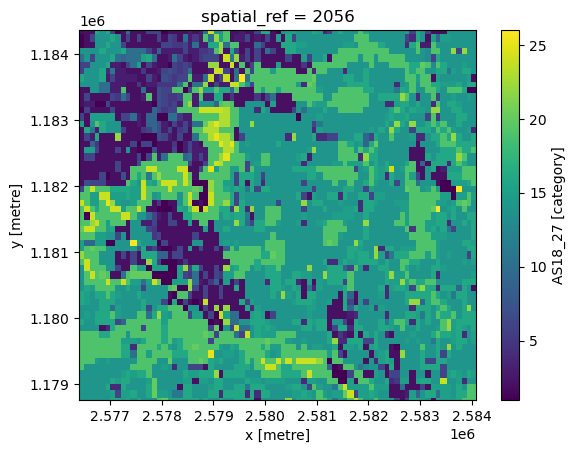

In [18]:
# First take a quick look at the land use for our area of interest
data.AS18_27.plot()

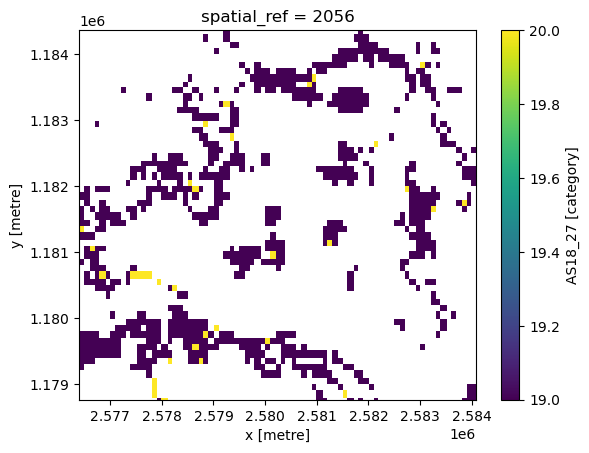

In [19]:
# Let's take a look at the regions of this area which are 'closed forest' and 'open forest'
data.AS18_27.where((data.AS18_27 >= 19) & (data.AS18_27 <= 20)).plot()

In [20]:
# Let's look at the value of NDVI in the forest areas.
# To do this we 'mask' the data using xarray's where() command
# Here we are specifying a range of values...
ndvi_in_forests = data.ndvi.where((data.AS18_27 >= 19) & (data.AS18_27 <= 20))

#... as another example, one could just look at a single category, for example rivers.
#rivers = data.AS18_27.where(data.AS18_27 == 24)

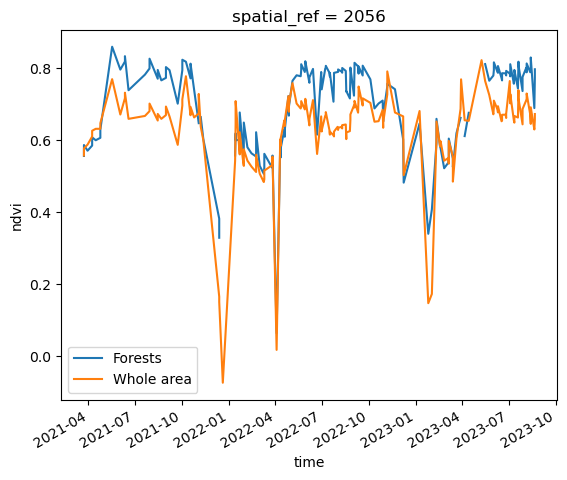

In [21]:
# We can calculate a mean through time
# - and compare it to the average of the whole area
ndvi_in_forests.mean(dim=('x','y')).plot(label='Forests')
data.ndvi.mean(dim=('x','y')).plot(label='Whole area')
plt.legend()